# Merchant Segmentation Notebook 🛒 💼

This notebook details the process of segmenting merchants to 3-5 categories. Initially, merchants are segmented into 25 different categories based on their product tags. However, we want to classify our merchants only to 3-5 categories. We will utilize `spaCy`'s `en_core_web_lg` embeddings which contains Word2vec embeddings that were fitted on Common Crawl data. The embeddings can be obtained from the command-line in the following manner:

`$ python -m spacy download en_core_web_lg`

We will need to specify the labels we want, then we will use K-nearest neighbour (KNN) to determine which label each product tag is closest to. 

Code inspired by: https://maxhalford.github.io/blog/unsupervised-text-classification/

In [1]:
# import constants
import sys
sys.path.append('../scripts/utils')
from constants import *

# import basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# import libraries for preprocessing
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

# import libraries for segmentation
import spacy
from sklearn.neighbors import NearestNeighbors

# create a Spark session
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

23/10/20 11:10:05 WARN Utils: Your hostname, vanessas-MacBook-Pro-3.local resolves to a loopback address: 127.0.0.1; using 192.168.18.7 instead (on interface en0)
23/10/20 11:10:05 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/20 11:10:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Specify Labels Here
Before we do any coding, we will first specify the labels first. Edit label names or number of labels here.

In [2]:
label_names =  ['technology', 'leisure luxury art', 'health wellness', 'repair services', 'appliances']

## Prepare Data
The first step is to prepare the data by preprocessing and cleaning the texts of product tags. After preprocessing, we see that we manage to narrow down the amount of product descriptions to just 25 unique product tags across all merchants.

In [3]:
# read data
tbl_merchants = pd.read_pickle(f"{CURATED_DATA}tbl_merchants.pkl")
tbl_consumers = pd.read_pickle(f"{CURATED_DATA}tbl_consumer.pkl")
transactions = spark.read.parquet(f"{TRANSACTION_DATA}")

# join to get transactions with merchants and consumers details
transactions_joined = transactions.join(spark.createDataFrame(tbl_consumers), on="user_id", how="inner") 
transactions_joined = transactions_joined.withColumnRenamed("name", "con_name")
transactions_joined = transactions_joined.join(spark.createDataFrame(tbl_merchants), on="merchant_abn", how="inner")
transactions_joined = transactions_joined.withColumnRenamed("name", "mer_name")

# download stopwords etc
nltk.download('wordnet') 
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to                                      
[nltk_data]     /Users/vanessafamdanny/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/vanessafamdanny/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vanessafamdanny/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
def remove_punctuation(input_string: str) -> str:
    '''
    Helper function to remove punctuations.
    Arguments:
      - input_string: string which requires puncutation removal
    Output:
      - the string with punctuation removed
    '''
    return re.sub(r'[^\w\s]', '', input_string)

def preprocess_products(tags: str) -> str:
    '''
    Helper function to perform all preprocessing steps.
    Arguments:
      - tags: string/product description to be preprocessed
    Output:
      - the preprocessed string
    '''

    # lower case all tags
    tags = tags.lower()

    # remove punctuations
    tags = remove_punctuation(tags)

    # remove extra whitespaces
    tags = " ".join(tags.split())

    # lemmatize
    lemmatizer = WordNetLemmatizer()
    tags_tokens = nltk.word_tokenize(tags)
    tags = [lemmatizer.lemmatize(token) for token in tags_tokens]
    tags = ' '.join(tags)

    # remove stop words
    custom_stop_words = set(stopwords.words('english'))
    custom_stop_words.update(["except", "shop", "store"])
    tags = nltk.word_tokenize(tags)    
    filtered_tags = [word for word in tags if word not in custom_stop_words]
    tags = ' '.join(filtered_tags)

    # remove duplicate words
    tags= ' '.join(sorted(set(tags.split()), key=tags.split().index))

    return tags

In [5]:
# preprocess all product descriptions
tbl_merchants['preprocessed_products'] = tbl_merchants['products'].apply(lambda x: preprocess_products(x))

In [6]:
tags = tbl_merchants['preprocessed_products'].unique()
print("Number of unique product tags:", len(tags))

Number of unique product tags: 25


## K-Nearest Neighbours (KNN) + Word Embeddings
Now, we will specify our labels, embed the product tags, then use KNN to determine which label each product tag belongs to.

In [7]:
# tokenize product tags
tags_list = []
for categ in tags:
    temp_list = [word for word in categ.split()]
    tags_list.append(temp_list)

In [8]:
# load spacy model
nlp = spacy.load('en_core_web_lg')

In [9]:
# helper function for embedding
def embed(tokens: list, nlp: spacy.lang.en.English) -> np.ndarray:
    """
    Helper function to return the centroid of the embeddings for the given tokens.
    Arguments:
      - tokens: product description to be embedded
      - nlp: the language model
    Output:
      - centroid of the embeddings
    """

    lexemes = (nlp.vocab[token] for token in tokens)

    vectors = np.asarray([
        lexeme.vector
        for lexeme in lexemes
        if lexeme.has_vector
        and not lexeme.is_stop
        and len(lexeme.text) > 1
    ])

    if len(vectors) > 0:
        centroid = vectors.mean(axis=0)
    else:
        width = nlp.meta['vectors']['width']  # typically 300
        centroid = np.zeros(width)

    return centroid

In [10]:
# embed the labels previously specified
label_vectors = np.asarray([embed(label.split(' '), nlp) for label in label_names])

In [11]:
# fit a KNN model
neigh = NearestNeighbors(n_neighbors = 1)
neigh.fit(label_vectors)

NearestNeighbors(n_neighbors=1)

In [12]:
# perform predictions
def predict(tokens: list, nlp: spacy.lang.en.English, neigh: NearestNeighbors) -> np.int64:
    '''
    Helper function to predict the category of a product description.
    Arguments:
      - tokens: tokenized product description
      - nlp:  the language model
      - neigh: KNN model
    Output:
      - the predicted category/label
    '''

    centroid = embed(tokens, nlp)
    closest_label = neigh.kneighbors([centroid], return_distance=False)[0][0]
    return closest_label

preds = [label_names[predict(doc, nlp, neigh)] for doc in tags_list]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/threadpoolctl.py:1010: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


In [13]:
#  results of clusters
result_df = pd.DataFrame({'product': tags, 'cluster': preds})
result_df

,product,cluster
0,furniture home furnishing equipment manufactur...,appliances
1,cable satellite pay television radio service,appliances
2,jewelry watch clock silverware,appliances
3,watch clock jewelry repair,appliances
4,music musical instrument piano sheet,leisure luxury art
5,gift card novelty souvenir,leisure luxury art
6,computer peripheral equipment software,technology
7,computer programming data processing integrate...,technology
8,equipment tool furniture appliance rent al lea...,appliances
9,artist supply craft,leisure luxury art


In [14]:
# join this to the merchant data, save to curated layer
merged_df = tbl_merchants.merge(result_df[['product', 'cluster']], left_on='preprocessed_products', right_on='product', how='left')
merged_df = merged_df.drop(columns=['product', 'products', 'category'])
merged_df.to_pickle(f"{CURATED_DATA}tbl_merchants_cluster.pkl")

## Segmentation Analysis
Analysis on the distribution of the different segments we specified.

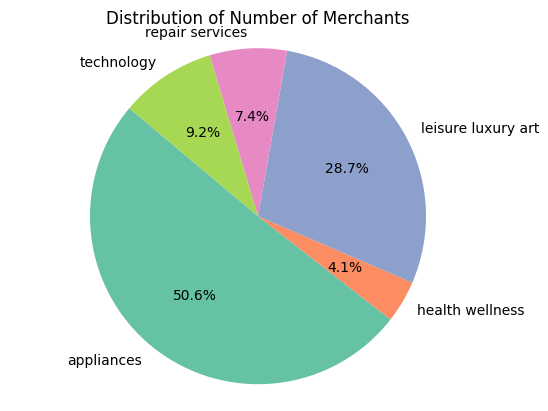

In [15]:
# distribution of the number of merchants
cluster_counts = (merged_df['cluster'].value_counts()).sort_index()

# Create a pie chart
plt.pie(cluster_counts, labels=cluster_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Distribution of Number of Merchants')
plt.axis('equal')  
plt.savefig(f'{MERCHANT_SEGMENT_PLOT}/num_merchants.jpg', dpi=300, bbox_inches="tight")

# Display the pie chart
plt.show()

In [16]:
# join cluster results to transactions data
cluster_df = merged_df.drop(columns=['name', 'revenue_levels', 'take_rate'])
cluster_sdf = spark.createDataFrame(cluster_df)
transactions_joined = transactions_joined.join(cluster_sdf, on ="merchant_abn", how='left')

In [17]:
# obtain aggregated values
cluster_agg = transactions_joined.groupBy("cluster").agg(
    F.sum("dollar_value").alias("total_revenue"),
    F.count("order_id").alias("total_orders"),
    F.median("dollar_value").alias("median_revenue")
).orderBy("cluster").toPandas()

cluster_agg["avg_revenue_per_order"] = cluster_agg["total_revenue"]/cluster_agg["total_orders"]

23/10/20 11:10:51 WARN TaskSetManager: Stage 2 contains a task of very large size (3029 KiB). The maximum recommended task size is 1000 KiB.


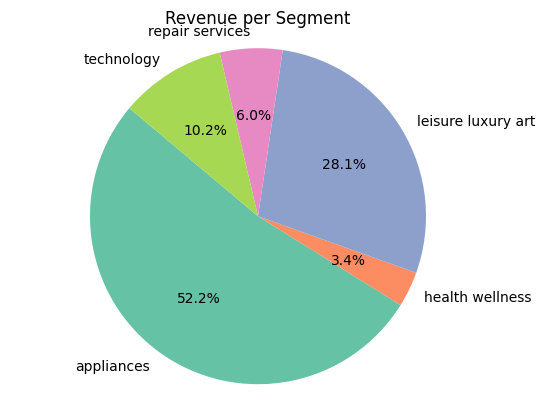

In [18]:
# pie chart of revenue per segment
plt.pie(cluster_agg["total_revenue"], labels=cluster_agg["cluster"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Revenue per Segment')
plt.axis('equal')  
plt.savefig(f'{MERCHANT_SEGMENT_PLOT}/revenue_merchants.jpg', dpi=300, bbox_inches="tight")

# Display the pie chart
plt.show()

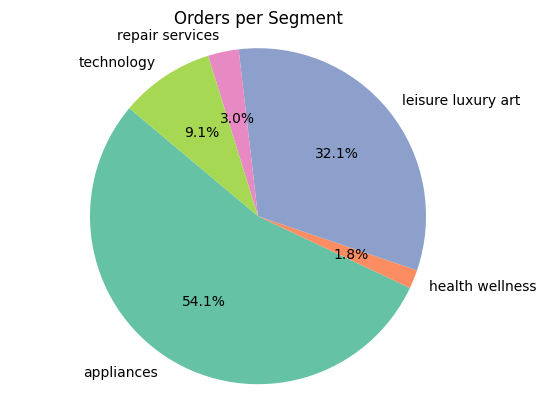

In [19]:
# pie chart of number of orders per segment
plt.pie(cluster_agg["total_orders"], labels=cluster_agg["cluster"], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Orders per Segment')
plt.axis('equal')  
plt.savefig(f'{MERCHANT_SEGMENT_PLOT}/number_order.jpg', dpi=300, bbox_inches="tight")

# Display the pie chart
plt.show()

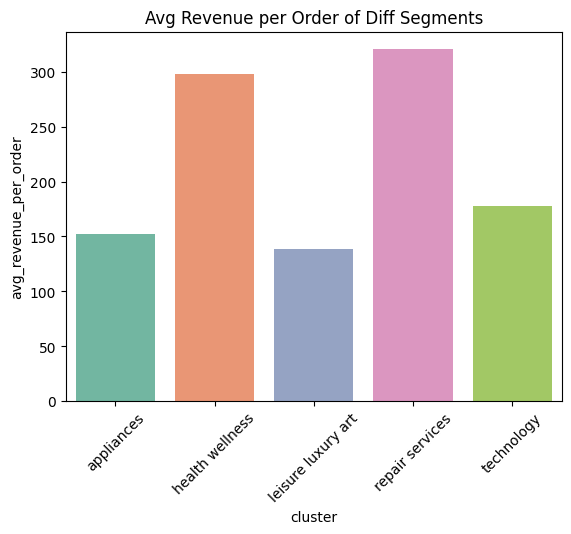

In [20]:
# average revenue per order
sns.set_palette("Set2")
sns.barplot(data=cluster_agg, x=cluster_agg["cluster"], y=cluster_agg["avg_revenue_per_order"])
plt.xticks(rotation=45)
plt.title("Avg Revenue per Order of Diff Segments")
plt.savefig(f'{MERCHANT_SEGMENT_PLOT}/avg_revenue.jpg', bbox_inches="tight", dpi=300)
plt.show()

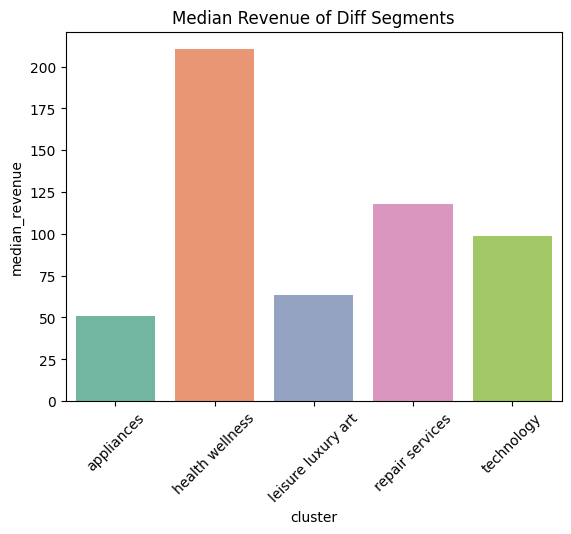

In [21]:
# median revenue of segments
sns.set_palette("Set2")
sns.barplot(data=cluster_agg, x=cluster_agg["cluster"], y=cluster_agg["median_revenue"])
plt.xticks(rotation=45)
plt.title("Median Revenue of Diff Segments")
plt.savefig(f'{MERCHANT_SEGMENT_PLOT}/median_revenue.jpg', bbox_inches="tight", dpi=300)
plt.show()